#Trabajo Práctico n° 8: Remuestreo y reconstrucción

Implementar un aplicativo que permita abrir una imagen y con esta obtener:

* Downsampling X2 utilizando kernel constante, bilineal, y bicúbico (mostrar la imagen resultado al doble de tamaño para comparar el efecto).
* Upsampling X2 utilizando kernel constante, bilineal, y bicúbico (mostrar la imagen resultado al doble de tamaño para comparar el efecto).
* Cuantización a cantidad de niveles de gris variable, utilizando uniforme, dithering aleatorio, y difusión del error por scan-line.

Todas las funciones de Downsamplig, Upsampling y Cuantización deben ser desarrolladas como funciones propias y NO con funciones de biblioteca. Les sugiero recorrer la imagen mediante ciclos for anidados para una fácil implementación.

In [46]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
import random

#Remuestreo

In [30]:
def apply_sample(img, sample_type):
  prep_img = img / 255
  
  #DOWNSAMPLING
    #CONSTANT
  def downsample_X2_constant(img):
    new_img = np.zeros((prep_img.shape[0] // 2, prep_img.shape[1] // 2))
    kernel = np.array([[1, 0],
                       [0, 0]])

    for (i, j), v in np.ndenumerate(new_img):
      new_img[i, j] = np.mean(prep_img[2 * i : 2 * i + 2, 2 * j : 2 * j + 2] * kernel)
    
    return new_img
  
    #BILINEAR
  def downsample_X2_bilinear(img):
    new_img = np.zeros((prep_img.shape[0] // 2, prep_img.shape[1] // 2))

    for (i, j), v in np.ndenumerate(new_img):
      new_img[i, j] = np.mean(prep_img[2 * i : 2 * i + 2, 2 * j : 2 * j + 2])
    
    return new_img
  
    #BICUBIC
  def downsample_X2_bicubic(img):
    new_img = np.zeros((prep_img.shape[0] // 2, prep_img.shape[1] // 2))
    dims = prep_img.shape
    #Duplication of edge samples
    prep_bicubic_img = np.zeros((dims[0] + 2, dims[1] + 2))
    prep_bicubic_img[1:-1, 1:-1] = prep_img
    prep_bicubic_img[0, 1:-1] = prep_img[0, :]
    prep_bicubic_img[-1, 1:-1] = prep_img[-1, :]
    prep_bicubic_img[1:-1, 0] = prep_img[:, 0]
    prep_bicubic_img[1:-1, -1] = prep_img[:, -1]
    kernel_line = np.array([-1, 5, 5, -1]) / 8

    for (i, j), v in np.ndenumerate(new_img):
      #print()
      new_img[i, j] = np.sum(prep_bicubic_img[2 * i : 2 * i + 4, 2 * j : 2 * j + 4] * np.outer(kernel_line, kernel_line))
    
    return new_img

  
  #UPSAMPLING
    #CONSTANT
  def upsample_X2_constant(img):
    new_img = np.zeros((prep_img.shape[0] * 2, prep_img.shape[1] * 2))
    kernel = np.array([[1, 1],
                      [1, 1]])

    for (i, j), v in np.ndenumerate(prep_img):
      new_img[2 * i : 2 * i + 2, 2 * j : 2 * j + 2] = prep_img[i, j] * kernel
    
    return new_img
  
    #BILINEAR
  def upsample_X2_bilinear(img):
    dims = prep_img.shape
    new_img = np.zeros((prep_img.shape[0] * 2 - 1, prep_img.shape[1] * 2 - 1))
    #Internal Interpolation
    for (i, j), v in np.ndenumerate(prep_img[:-1, :-1]):
      new_img[2 * i    , 2 * j]     = prep_img[i, j]
      new_img[2 * i + 1, 2 * j]     = np.mean(prep_img[i : i + 2, j])
      new_img[2 * i    , 2 * j + 1] = np.mean(prep_img[i, j : j + 2])
      new_img[2 * i + 1, 2 * j + 1] = np.mean(prep_img[i : i + 2, j : j + 2])
    #Edge Interpolation
    for i in range(dims[0] - 1):
      new_img[2 * i    , -1] = prep_img[i, -1]
      new_img[2 * i + 1, -1] = np.mean(prep_img[i : i + 2, -1])
    for j in range(dims[1] - 1):
      new_img[-1, 2 * j]     = prep_img[-1, j]
      new_img[-1, 2 * j + 1] = np.mean(prep_img[-1, j : j + 2])
    new_img[-1, -1] = prep_img[-1, -1]
    return new_img
  
    #BICUBIC
  def upsample_X2_bicubic(img):
    dims = prep_img.shape
    #Duplication of edge samples
    prep_bicubic_img = np.zeros((dims[0] + 2, dims[1] + 2))
    prep_bicubic_img[1:-1, 1:-1] = prep_img
    prep_bicubic_img[0, 1:-1] = prep_img[0, :]
    prep_bicubic_img[-1, 1:-1] = prep_img[-1, :]
    prep_bicubic_img[1:-1, 0] = prep_img[:, 0]
    prep_bicubic_img[1:-1, -1] = prep_img[:, -1]
    new_img = np.zeros((dims[0] * 2 - 1, dims[1] * 2 - 1))
    kernel_line = np.array([-1, 5, 5, -1]) / 8
    #Internal Interpolation
    for (i, j), v in np.ndenumerate(prep_img[:-1,:-1]):
      new_img[2 * i    , 2 * j]     = prep_img[i, j]
      new_img[2 * i + 1, 2 * j]     = np.sum(prep_bicubic_img[i : i + 4, j] * kernel_line)
      new_img[2 * i    , 2 * j + 1] = np.sum(prep_bicubic_img[i, j : j + 4] * kernel_line)
      new_img[2 * i + 1, 2 * j + 1] = np.sum(prep_bicubic_img[i : i + 4, j : j + 4] * np.outer(kernel_line, kernel_line))
    #Edge Interpolation
    for i in range(dims[0] - 1):
      new_img[2 * i    , -1] = prep_img[i, -1]
      new_img[2 * i + 1, -1] = np.sum(prep_bicubic_img[i : i + 4, -1] * kernel_line)
    for j in range(dims[1] - 1):
      new_img[-1, 2 * j]     = prep_img[-1, j]
      new_img[-1, 2 * j + 1] = np.sum(prep_bicubic_img[-1, j : j + 4] * kernel_line)
    new_img[-1, -1] = prep_img[-1, -1]
    return new_img


  #SELECTION
  if sample_type == 'Downsampling X2 constante':
    new_img = downsample_X2_constant(img)
  elif sample_type == 'Downsampling X2 bilineal':
    new_img = downsample_X2_bilinear(img)
  elif sample_type == 'Downsampling X2 bicubico':
    new_img = downsample_X2_bicubic(img)
  elif sample_type == 'Upsampling X2 constante':
    new_img = upsample_X2_constant(img)
  elif sample_type == 'Upsampling X2 bilineal':
    new_img = upsample_X2_bilinear(img)
  elif sample_type == 'Upsampling X2 bicubico':
    new_img = upsample_X2_bicubic(img)

  return np.uint8(np.clip(new_img * 255, 0, 255))

En los métodos de renmuestreo bilineal y bicúbico, la resolución de la nueva imagen no es exactamente el doble, sino que, para una imagen de $n \times m$, la imagen resultante será de $(2n - 1) \times (2m - 1)$. 

Esta decisión se tomó debido a que estos métodos implementan una interpolación, por lo que es adecuado pensar que las últimas fila y columna de la nueva imagen contengan los muestreos de la imagen original, a diferencia de lo que ocurría en el remuestreo constante.

Para el caso del remuestreo bicúbico, las condiciones de borde consideradas fueron las de duplicar las filas y columnas de muestreo del contorno.

(170, 170)


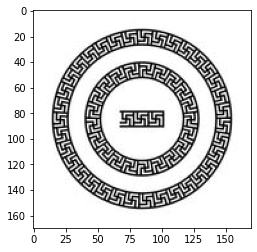

In [32]:
#URL = 'torax.jpeg'
URL = 'pattern.jfif' #good pattern
img = imageio.imread(URL)

if (len(img.shape) > 2):
  img = img[:, :, 0]

plt.set_cmap('gray')
plt.imshow(img)

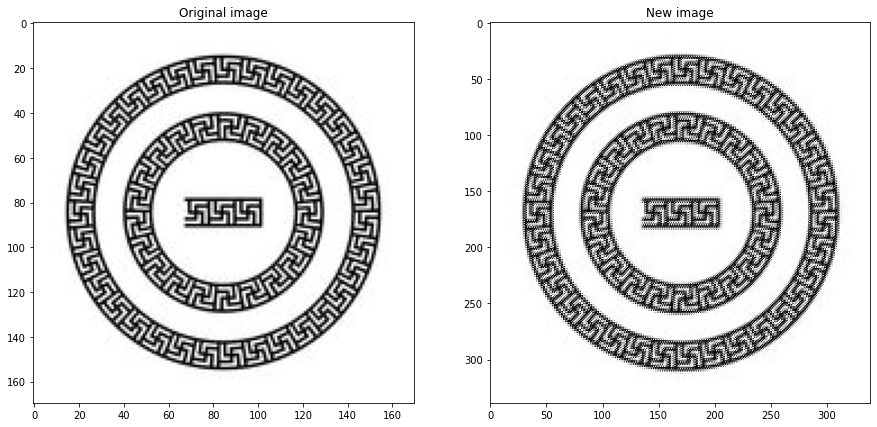

In [36]:
#@title Pick a sampling method {run:"auto"}
sample_type = 'Upsampling X2 bicubico' #@param ['Downsampling X2 constante', 'Downsampling X2 bilineal', 'Downsampling X2 bicubico', 'Upsampling X2 constante', 'Upsampling X2 bilineal', 'Upsampling X2 bicubico']

#IMAGE PROCESSING
new_img = apply_sample(img, sample_type)

#PLOTTING
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title('Original image')

ax[1].imshow(new_img)
ax[1].set_title('New image')
plt.show()

#Cuantización

In [2]:
#CONVERSION BETWEEN RGB AND YIQ SPACES
def RGBtoYIQ(img_rgb):
  coef = np.array([[   0.299,     0.587,     0.114],
                   [0.595716, -0.274453, -0.321263],
                   [0.211456, -0.522591,  0.311135]])
  
  img_norm = img_rgb / 255 #Normalization of RGB vector
  dims = img_rgb.shape
  img_yiq = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_yiq[i, j, :] = np.matmul(coef, img_norm[i, j, :])
  np.clip(img_yiq[:,:,0],       0,      1, out=img_yiq[:,:,0])  #       0 <= Y <= 1
  np.clip(img_yiq[:,:,1], -0.5957, 0.5957, out=img_yiq[:,:,1])  # -0.5957 <= I <= 0.5957
  np.clip(img_yiq[:,:,2], -0.5226, 0.5226, out=img_yiq[:,:,2])  # -0.5226 <= Q <= 0.5226
  return img_yiq

def YIQtoRGB(img_yiq):
  coef = np.array([[1,  0.9663,  0.6210],
                   [1, -0.2721, -0.6474],
                   [1, -1.1070,  1.7046]])
  
  dims = img_yiq.shape
  img_norm_rgb = np.zeros(dims)
  for i in range(dims[0]):
    for j in range(dims[1]):
      img_norm_rgb[i, j, :] = np.matmul(coef, img_yiq[i, j, :])
  np.clip(img_norm_rgb, 0, 1, out=img_norm_rgb)
  return np.uint8(np.floor(img_norm_rgb * 255)) #De-normalization of normalized RGB vector

(352, 498, 3)


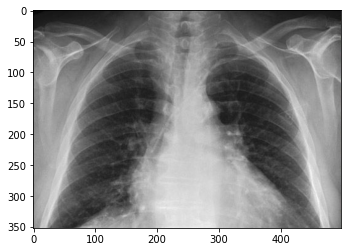

In [39]:
URL = 'torax.jpeg'
#URL = 'pattern.jfif' #good pattern
img = imageio.imread(URL)

plt.set_cmap('gray')
plt.imshow(img)

In [78]:
def apply_cuantitazion(img, cuant_type, n=4):
  yiq_img = RGBtoYIQ(img)
  lum_vector = np.array([i/(n - 1) for i in range(n)])

  #UNIFORM
  def u_cuantize(img):
    new_yiq = np.zeros(img[:, :, 0].shape)
    for (i, j), v in np.ndenumerate(yiq_img[:, :, 0]):
      new_yiq[i, j] = lum_vector[np.int(np.floor( (n-1) * v + 1 / 2))] #Le sumo la mitad del intervalo para trasladarla
    return new_yiq
  
  #RANDOM DITHERING
  def random_dithering(img):
    new_yiq = np.zeros(img[:, :, 0].shape)
    for (i, j), v in np.ndenumerate(yiq_img[:, :, 0]):
      new_yiq[i, j] = lum_vector[np.int(np.floor( (n - 1) * v + random.random()))]
    return new_yiq
  
  #ERROR DIFUSSION DITHERING
  def errdif_dithering(img):
    new_yiq = np.zeros(img[:, :, 0].shape)
    error = 0
    for (i, j), v in np.ndenumerate(yiq_img[:, :, 0]):
      new_yiq[i, j] = lum_vector[np.int(np.floor( (n - 1) * v + error))]
      error += v - new_yiq[i, j]
    return new_yiq

  #SELECTOR
  if cuant_type == 'Uniforme':
    yiq_img[:, :, 0] = u_cuantize(img)
  elif cuant_type == 'Dithering aleatorio':
    yiq_img[:, :, 0] = random_dithering(img)
  elif cuant_type == 'Dithering con difusion de error':
    yiq_img[:, :, 0] = errdif_dithering(img)


  return YIQtoRGB(yiq_img)

Para la implementación de la cuantización, se decidió generar un vector de valores de tamaño $n$, donde cada celda contiene un valor de luminancia. Lugo, para seleccionar la celda, se utiliza la siguiente función:

$ \lfloor (n-1)(x + a) \rfloor = \lfloor (n-1)x + (n-1)a\rfloor $

donde $x$ es el valor de luminancia de entrada, y el valor $a$ es el desplazamiento que va a sufrir según el tipo de cuantización que se utilice:

* Para la **cuatización uniforme**, $a=\dfrac{1}{2(n - 1)}$, es decir, la mitad del intervalo de asignación de un valor en el vector, que se le suma a la luminancia de entrada para desplazarla a la izquierda medio intervalo de distancia.
* Para la **cuantización por dithering aleatorio**, $a= noise(x)$, es decir, se desplaza la luminancia de entrada una distancia aleatoria hacia la izquierda.
* Para el **dithering por difusión de error**, $a=error$, donde $error=x - x_{nuevo}$, es decir, la diferencia acumulada entre la luminancia de entrada y la luminancia calculada. 

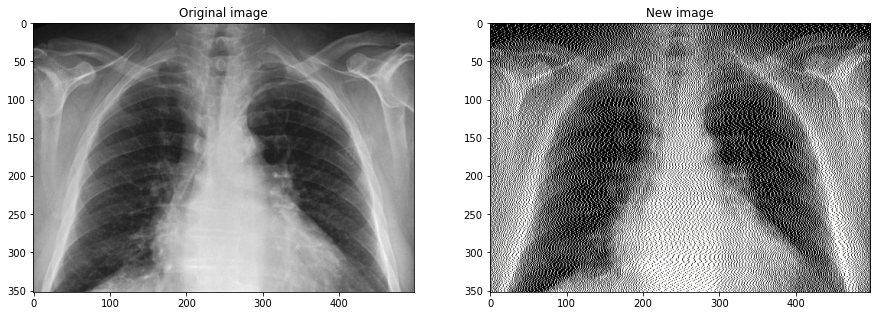

In [77]:
#@title Pick a sampling method {run:"auto"}

cuant_type = 'Dithering con difusion de error' #@param ['Uniforme', 'Dithering aleatorio', 'Dithering con difusion de error']
n = 2 #@param {type:"slider", min:2, max:256, step:1}

#IMAGE PROCESSING
new_img = apply_cuantitazion(img, cuant_type, n)

#PLOTTING
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(img)
ax[0].set_title('Original image')

ax[1].imshow(new_img)
ax[1].set_title('New image')
plt.show()